# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---

# Step -1: Install requirements

Firstly, you should

    pip install -r requirements.txt

---
## Step 0: Load The Data

This step downloads Udacity German Signs dataset and extracts it to `dataset` folder. An original file will be stored as `traffic-signs-data.zip`.

In [1]:
import downloader

# Download Udacity German Signs dataset and extract it to dataset folder
DATASET_URL = "https://d17h27t6h515a5.cloudfront.net/topher/2017/February/5898cd6f_traffic-signs-data/traffic-signs-data.zip"
downloader.download_and_extract(DATASET_URL, 'traffic-signs-data.zip', 'dataset')

print('Dataset is extracted to "dataset" folder.')

Dataset: 124MB [00:21, 5.70MB/s]                                                                                                                     


Dataset extracted to "dataset" folder.


Then load dataset into memory:

In [2]:
import helpers

train = helpers.load_samples("dataset/train.p")
valid = helpers.load_samples("dataset/valid.p")
test = helpers.load_samples("dataset/test.p")

# check datasets
assert len(train.features) == len(train.labels)
assert len(valid.features) == len(valid.labels)
assert len(test.features) == len(test.labels)

`train` samples are used to train model, `valid` samples serve to measure training performance, and the purpose of `test` samples is to evaluate the final accuracy. 

`train` and `valid` samples will be augmented (see below), `test` samples will not change.

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
n_train = len(train.features)

n_validation = len(valid.features)

n_test = len(test.features)

image_shape = train.features[0].shape

all_classes = valid.labels_set.union(valid.labels_set).union(test.labels_set)

n_classes = len(all_classes)

print("Number of training examples =", n_train)
print("Number of testing examples = %s (%.2f %%)" %(n_test, n_test / n_train * 100))
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630 (36.29 %)
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

import numpy as np

Let's output a count of samples for each class:

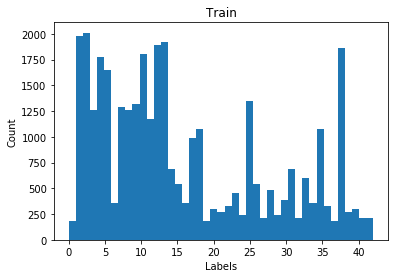

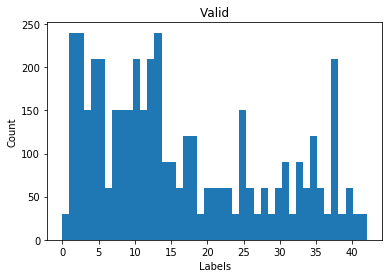

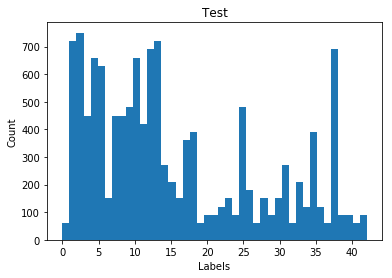

In [6]:
def show_hist(title, samples, n_classes):
    plt.hist(samples.labels, bins=n_classes)
    plt.title(title)
    plt.xlabel("Labels")
    plt.ylabel("Count")
    plt.xticks(range(0, 43, 5))
    plt.show()
    
show_hist('Train', train, n_classes)
show_hist('Valid', valid, n_classes)
show_hist('Test', test, n_classes)

Histograms are very similar, but there are not enough samples for some classes.

The following script displays one image per class:

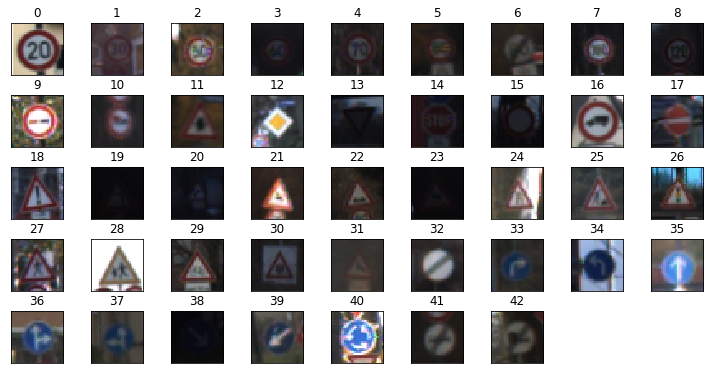

In [7]:
helpers.show_all_signs(train, n_classes)

----

## Step 2: Design and Test a Model Architecture

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf).

### Pre-process the Data Set (normalization, grayscale, etc.)

I decided to add more samples for the `train` and `valid` datasets. Tranditional transformations and color pertrubation were used for these purposes:
* rotate using a random angle (from -15 to 15 degrees)
* change brightness using a random factor
* change contrast using a random factor

See `auglib.py` source code for for more details.

In [8]:
import auglib

augmented_train = auglib.augment_samples(train, angle_degree=15,
                                         brightness_max_delta=0.1,
                                         contrast_lower=0.8, contrast_upper=1.2)

augmented_valid = auglib.augment_samples(valid, angle_degree=15,
                                         brightness_max_delta=0.1,
                                         contrast_lower=0.8, contrast_upper=1.2)

train = train.append(augmented_train)
valid = valid.append(augmented_valid)

n_train = len(train.features)

n_validation = len(valid.features)

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)

Number of training examples = 69598
Number of validation examples = 8820


Here are the augmented images:

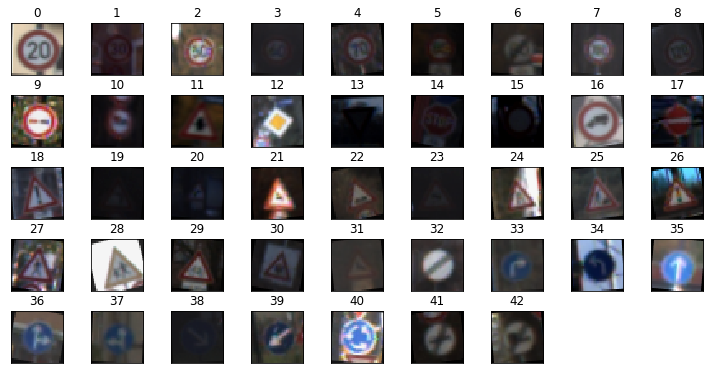

In [9]:
helpers.show_all_signs(augmented_train, n_classes)

### Model Architecture

I used LeNet 5 network from [lessons](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81), but I also added normalization layer and two dropout layers (to prevent overfitting). 

Normalization layer first centers each image around its mean value (see Traffic Sign Recognition with Multi-Scale Convolutional Networks) and then normalizes values with std. Each image is turned into (-1, 1) image.

The model contains:
* normalization layer
* CNN layer conv1: 32x32x3 => 14x14x6
* CNN layer conv2: 14x14x6 => 5x5x16
* Dropout 0.8
* Flatten layer: 400
* Fully-connected layer fc1: 400 => 120
* Dropout 0.8
* Fully-connected layer fc2: 120 => 84
* Fully-connected layer fc3: 84 => 43 (a number of classes)
* output layer

Let's define inputs and outputs. I use one-hot encoding for labels.

In [10]:
import tensorflow as tf

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

with tf.name_scope('input'):
    x = tf.placeholder(tf.float32, (None, *image_shape), name="x")
    
with tf.name_scope('output'):
    y = tf.placeholder(tf.int32, (None), name="y")
    one_hot_y = tf.one_hot(y, n_classes, name="one_hot_y")

Next define control placeholders for `learning rate` and `keep probability`:

In [11]:
learning_rate = tf.placeholder(tf.float32, name='learning_rate')
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

`LeNet` function builds LeNet-5 network:

In [15]:
from tensorflow.contrib.layers import flatten


def normalize(x):
    return tf.map_fn(tf.image.per_image_standardization, x)

    
def LeNet(x, channels, classes, keep_prob):
    """LeNet builds LeNet-5 DNN

    Parameters:
      - x - an input tensor
      - channels - a count of input channels (3 for RGB, 1 for Gray scale)
      - classes - a count of classes
      - keep_prob - keep probability tensor (should be 1 for validation)

    """

    # Hyperparameters
    mu = 0
    sigma = 0.1

    # normalize
    x = normalize(x)
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x<channels>. Output = 28x28x6.
    with tf.name_scope('conv1'):
        conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, channels, 6), mean = mu, stddev = sigma))
        conv1_b = tf.Variable(tf.zeros(6))
        conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

        # SOLUTION: Activation.
        conv1 = tf.nn.relu(conv1, name='activation')

        # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
        conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='maxpool')

    with tf.name_scope('conv2'):
        # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
        conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
        conv2_b = tf.Variable(tf.zeros(16))
        conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

        # SOLUTION: Activation.
        conv2 = tf.nn.relu(conv2, name='activation')        

        # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
        conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID', name='maxpool')

    dropout = tf.nn.dropout(conv2, keep_prob)

    with tf.name_scope('flatten'):
        # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
        fc0   = flatten(dropout)

    with tf.name_scope('fc1'):
        # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
        fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
        fc1_b = tf.Variable(tf.zeros(120))
        fc1   = tf.matmul(fc0, fc1_W) + fc1_b

        # SOLUTION: Activation.
        fc1    = tf.nn.relu(fc1, name='activation')

    fc1 = tf.nn.dropout(fc1, keep_prob)

    with tf.name_scope('fc2'):
        # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
        fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
        fc2_b  = tf.Variable(tf.zeros(84))
        fc2    = tf.matmul(fc1, fc2_W) + fc2_b

        # SOLUTION: Activation.
        fc2    = tf.nn.relu(fc2, name='activation')

    with tf.name_scope('fc3'):
        # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = classes.
        fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, classes), mean = mu, stddev = sigma))
        fc3_b  = tf.Variable(tf.zeros(classes))
        logits = tf.matmul(fc2, fc3_W) + fc3_b

    logits = tf.identity(logits, name='logits')

    return logits

Let's build LeNet-5 network. `logits` tensor can be used to get predictions.

In [16]:
channels = 3 # I use RGB images

logits = LeNet(x, channels, n_classes, keep_prob)

### Train, Validate and Test the Model

I used `softmax_cross_entropy_with_logits` and mean minization as error function (the most frequent choice for classification).

I use AdamOptimizer. AdamOptimizer chooses step size more accurately and demonstrates good performance.

In [17]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, 
                                                        logits=logits, 
                                                        name='cross_entropy')

cost = tf.reduce_mean(cross_entropy, name='cost')

with tf.name_scope('optimizer'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

`accuracy_operation` and utility function `calc_accuracy` were defined to evaluate model accuracy. `print_stats` helper calculates accuracy using `train` and `valid` samples and displays it.

In [18]:
# tensors to evaluate accuracy
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='batch_accuracy')

In [19]:
def calc_accuracy(sess, x, y, keep_prob, accuracy_op, batch_size, samples):   
    total_accuracy = 0.0

    for batch in samples.batches(batch_size):
        accuracy = sess.run(accuracy_op, feed_dict={x: batch.features, y: batch.labels, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch))

    accuracy = total_accuracy / len(samples)

    return accuracy


def print_stats(sess, epoch, batch_size, train_samples, valid_samples):
    global x
    global y
    global keep_prob
    global accuracy_operation
    
    train_accuracy = calc_accuracy(sess, x, y, keep_prob, accuracy_operation, batch_size, train_samples)

    valid_accuracy = calc_accuracy(sess, x, y, keep_prob, accuracy_operation, batch_size, valid_samples)

    print("Epoch %4s: train accuracy %.3f, valid accuracy %.3f " % 
          (epoch + 1, train_accuracy, valid_accuracy))

# Hyperparameters

In [20]:
EPOCHS = 10
BATCH_SIZE = 128
LEARNING_RATE = 0.001
KEEP_PROBABILITY = 0.8

10 `EPOCHS` is enough to reach target accuracy (> 0.93).

`BATCH_SIZE` number is based on the RAM size of my Video Card.

`LEARNING_RATE` 0.001 looks reasonable.

`KEEP_PROBABILITY` 0.8 (plus 2 dropout layers) should prevent overfitting.

## Train

Everything is ready to train model and save it to `SAVE_MODEL_PATH`.

In [21]:
SAVE_MODEL_PATH = 'trained_model/model'

Training requires about 10 minutes with NVidia GeForce GTX 750 Ti 2Gb:

In [22]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(EPOCHS):
        shuffled = train.shuffle()
        for batch in shuffled.batches(BATCH_SIZE):
            sess.run(optimizer,      
                     feed_dict={
                         x: batch.features, 
                         y: batch.labels, 
                         learning_rate: LEARNING_RATE, 
                         keep_prob: KEEP_PROBABILITY})
            
        print_stats(sess, epoch, BATCH_SIZE, shuffled, valid)
        
    saver.save(sess, SAVE_MODEL_PATH)
    
    test_accuracy = calc_accuracy(sess, x, y, keep_prob, accuracy_operation, BATCH_SIZE, test)
    
print('Trained with %.3f!' % test_accuracy)

Epoch    1: train accuracy 0.945, valid accuracy 0.870 
Epoch    2: train accuracy 0.976, valid accuracy 0.912 
Epoch    3: train accuracy 0.983, valid accuracy 0.915 
Epoch    4: train accuracy 0.991, valid accuracy 0.933 
Epoch    5: train accuracy 0.993, valid accuracy 0.937 
Epoch    6: train accuracy 0.993, valid accuracy 0.944 
Epoch    7: train accuracy 0.995, valid accuracy 0.944 
Epoch    8: train accuracy 0.996, valid accuracy 0.945 
Epoch    9: train accuracy 0.997, valid accuracy 0.947 
Epoch   10: train accuracy 0.996, valid accuracy 0.952 
Trained with 0.953!


## Checkpoint

The trained model is saved to `SAVE_MODEL_PATH` and can be loaded from disk any moment (see `with_model` function below).

---

## Step 3: Test a Model on New Images

9 images were downloaded from Web and saved to `real_signs` folder to test the model on real data.

### Load and Output the Real Images

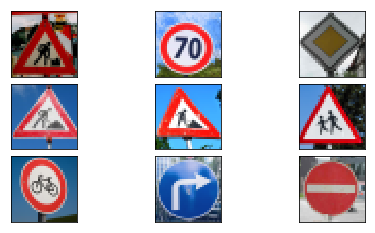

In [23]:
import os

import cv2


# Path to folder with "real-world" german signs
REAL_SIGNS_FOLDER = 'real_signs'


if not os.path.isdir(REAL_SIGNS_FOLDER):
    raise RuntimeError('oops, real_signs is not found')

    
def list_real_signs():
    """list_real_signs is a generator that returns file name for each real sign"""
    for filename in sorted(os.listdir(REAL_SIGNS_FOLDER)):
        yield os.path.join(REAL_SIGNS_FOLDER, filename)
        
        
def scale(image):
    return cv2.resize(image, (image_shape[0], image_shape[1]), interpolation = cv2.INTER_AREA)


def read_real_signs():
    """read_real_sings returns 4D array with images"""
    images = [scale(plt.imread(filename)) for filename in list_real_signs()]
    return np.array(images)


real_signs = read_real_signs()
# real_labels contains true label for each sign
real_labels = [25, 4, 12, 25, 25, 28, 29, 33, 17]

real_samples = helpers.Samples(real_signs, real_labels)

helpers.show_images(real_signs)

### Predict the Sign Type for Each Image

`with_model` function loads model from disk and runs the action that is passed as second parameter:

In [25]:
import tensorflow as tf


class Model:
    
    def __init__(self, save_model_path, top_k=5):
        self.save_model_path = save_model_path
        self.graph = tf.Graph()
        self.sess = None
        self.top_k = top_k
        
    def init(self, sess):
        self.sess = sess
        
        loader = tf.train.import_meta_graph(self.save_model_path + '.meta')
        loader.restore(sess, self.save_model_path)
        
        self.x = self.graph.get_tensor_by_name('input/x:0')
        self.y = self.graph.get_tensor_by_name('output/y:0')
        self.keep_prob = self.graph.get_tensor_by_name('keep_prob:0')
        self.logits = self.graph.get_tensor_by_name('logits:0')
        self.accuracy = self.graph.get_tensor_by_name('batch_accuracy:0')
        
    def calc_accuracy(self, batch_size, samples):
        return calc_accuracy(self.sess, self.x, self.y, self.keep_prob, self.accuracy, 
                             batch_size, samples)
    
    def predict(self, images):
        prediction = tf.nn.top_k(tf.nn.softmax(self.logits), self.top_k)
        return self.sess.run(prediction, feed_dict={self.x: images, self.keep_prob: 1.0})


def with_model(save_model_path, action):
    model = Model(save_model_path)

    with tf.Session(graph=model.graph) as sess:
        model.init(sess)
        return action(model)

Load the saved model from disk and test its accuracy to be sure we work with the right model:

In [26]:
def print_accuracy(model):
    print('Loaded model accuracy: %.3f' % model.calc_accuracy(BATCH_SIZE, test))
                
with_model(SAVE_MODEL_PATH, print_accuracy)

INFO:tensorflow:Restoring parameters from trained_model/model
Loaded model accuracy: 0.953


### Analyze Performance

Calculate the accuracy of the model using real images:

In [27]:
import functools

def print_real_accuracy(model):
    print('Accuracy on real-world images: %.3f' % model.calc_accuracy(BATCH_SIZE, real_samples))

with_model(SAVE_MODEL_PATH, print_real_accuracy)

INFO:tensorflow:Restoring parameters from trained_model/model
Accuracy on real-world images: 0.667


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from trained_model/model


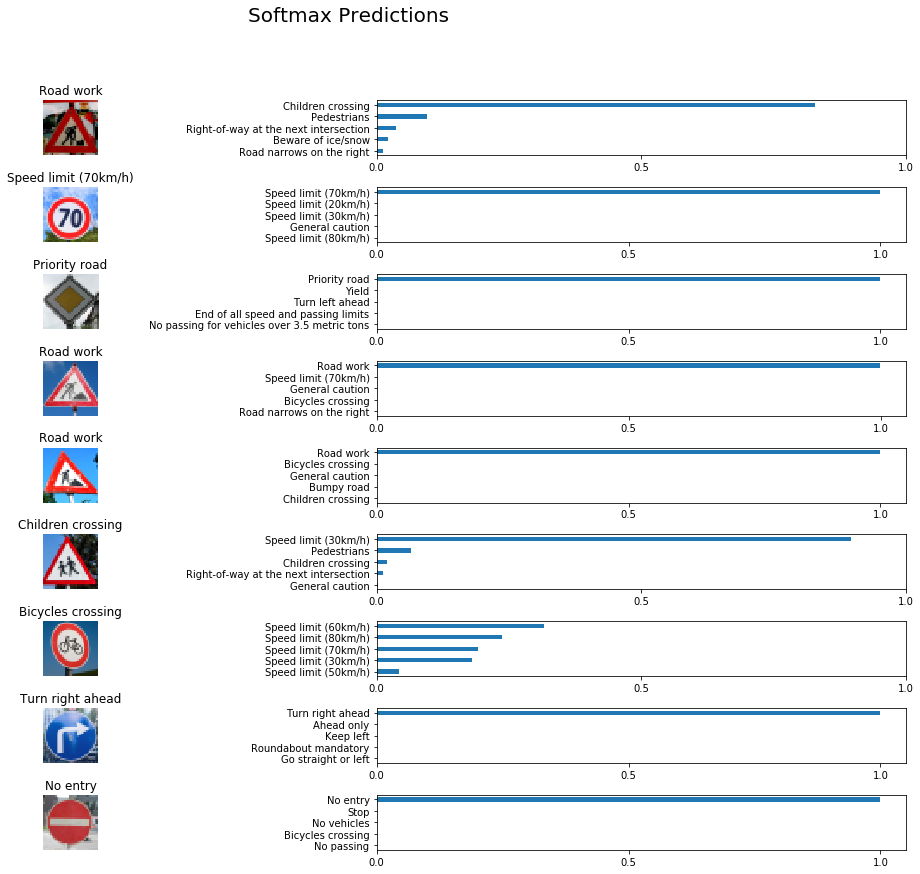

In [28]:
def predict(images, model):
    return model.predict(images)

predictions = with_model(SAVE_MODEL_PATH, 
                         functools.partial(predict, real_signs))

# Load human-readable labels from file
labels = helpers.load_labels('signnames.csv')

helpers.show_softmax_predictions(real_samples, predictions, labels, n_classes)

### Project Writeup

You can find my writeup in the current directory (writeup.pdf).

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

I use the existing function `outputFeatureMap` to visualize CNN layers.

In [29]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(model, image_input, op, title, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation_tensor = op.outputs[0]
    activation = model.sess.run(activation_tensor, feed_dict={model.x: image_input, model.keep_prob: 1.0})
    assert activation is not None
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.title(title)
    plt.show()

INFO:tensorflow:Restoring parameters from trained_model/model


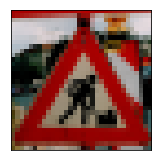

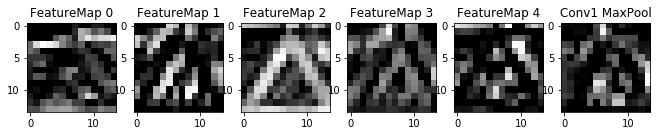

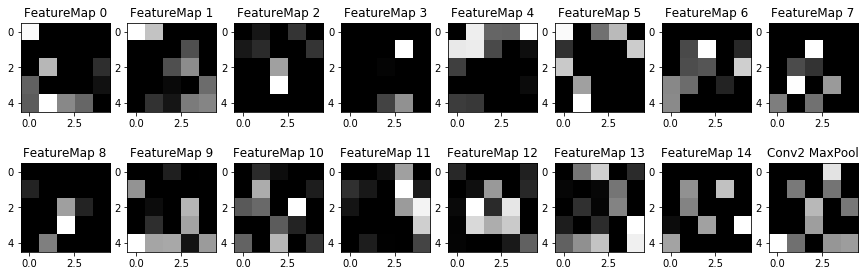

In [30]:
from functools import partial


def visualize(images, model):
    helpers.show_images(images)
    
    sess = model.sess
    
    conv1_maxpool = model.graph.get_operation_by_name('conv1/maxpool')
    conv2_maxpool = model.graph.get_operation_by_name('conv2/maxpool')
    
    outputFeatureMap(model, images, conv1_maxpool, 'Conv1 MaxPool')
    outputFeatureMap(model, images, conv2_maxpool, 'Conv2 MaxPool')
        

with_model(SAVE_MODEL_PATH, partial(visualize, real_signs[:1]))